In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.utils import shuffle
import itertools
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from underthesea import word_tokenize, text_normalize

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers

import codecs

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# load data
def load_data(path):
    data = pd.read_csv(path, encoding='utf-8', sep='\t')
    return data

In [42]:
# create stopword list
def create_stopwords():
    file = codecs.open('./vietnamese-stopwords.txt', encoding='utf-8')
    stopwords = []
    for i, line in enumerate(file):
        line = repr(line)
        line = line[1:len(line)-3] # remove '\r\n' 
        stopwords.append(line)
    file.close()
    return stopwords 

In [43]:
stopwords_list = create_stopwords()

In [44]:
import string
def tokenize(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return [word for word in word_tokenize(
        text_normalize(text), format="text").split() if word not in stopwords_list]

In [45]:
def vectorize_data():
    vectorizer = TfidfVectorizer(
        tokenizer=tokenize,
        ngram_range=(1, 4),
        min_df=5,
        max_df=0.8,
        max_features=15000,
        sublinear_tf=True,
        encoding='utf-8',
    )
    return vectorizer

In [46]:
df_train = load_data('./vlsp_sentiment_train.csv')
df_test = load_data('./vlsp_sentiment_test.csv')

In [47]:
df_train.shape, df_test.shape

((5100, 2), (1050, 2))

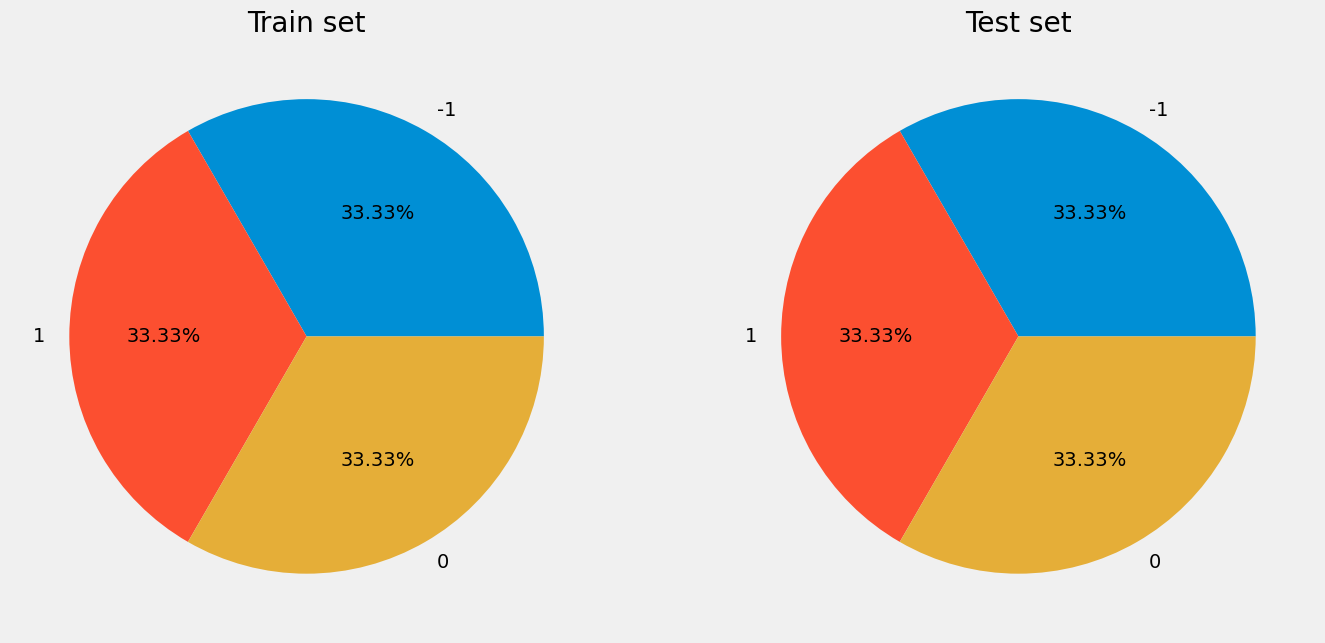

In [48]:
# Visualize data distribution in train set and test set with pie chart
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
df_train_classes = df_train['Class'].value_counts()
df_test_classes = df_test['Class'].value_counts()

df_train_classes.plot.pie(autopct='%.2f%%', ax=ax[0])
df_test_classes.plot.pie( autopct='%.2f%%', ax=ax[1])

ax[0].set_title('Train set')
ax[1].set_title('Test set')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.show()

In [49]:
# Preprocessing data
reviews = df_train['Data'].values
labels =   df_train['Class'].values

In [50]:
encoded_labels = []
for label in labels:
    if label == -1:
        encoded_labels.append([1, 0, 0])
    elif label == 0:
        encoded_labels.append([0, 1, 0])
    else:
        encoded_labels.append([0, 0, 1])
encoded_labels = np.array(encoded_labels)

In [51]:
import re
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"  
                           "]+", flags=re.UNICODE)

In [52]:
def text_cleaner(text):
    # lower case text
    text = text.lower()
    # remove emojis
    text = re.sub(emoji_pattern, " ", text)
    # reduce repeated characters
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # make sure punctuation is in the right letter
    text = text_normalize(text)
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [53]:
processed_reviews = []
unlabelled_reviews = []

for review in reviews:
    # Remove punctuation
    review = review.replace('!','').replace('?','').replace('.','').replace(',','').replace('(','').replace(')','')
    # Remove numbers
    review = ''.join([i for i in review if not i.isdigit()])
    # Remove extra spaces
    review = ' '.join(review.split())
    # Remove stopwords
    review = ' '.join([word for word in review.split() if word.lower() not in stopwords_list])
    # Remove unlabelled reviews
    if review == '':
        unlabelled_reviews.append(review)
    else:
        processed_reviews.append(review)

In [54]:
# from pyvi import ViTokenizer
# review_words  = []
# all_words = []
# for review in processed_reviews:
#     review_words.append(ViTokenizer.tokenize(review).split())
#     all_words += ViTokenizer.tokenize(review).split()

In [55]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [56]:
review_words = []
all_words = []

for review in processed_reviews:
    review_words.append(tokenize(review))
    all_words += tokenize(review)

In [57]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 400

In [58]:
# tokenize data
review_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=True,
    char_level=False,
)

review_tokenizer.fit_on_texts(review_words)
word_index = review_tokenizer.word_index
vocab_size = len(word_index) + 1

print('Found %s unique tokens.' % len(word_index))

Found 13107 unique tokens.


In [59]:
sequences = review_tokenizer.texts_to_sequences(review_words)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
labels = encoded_labels

print('Shape of data tensor:', data.shape)

Shape of data tensor: (5086, 300)


In [60]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format('./vi-model-CBOW.bin', binary=True)

In [61]:
vocabularies_size = min(len(word_index) + 1, MAX_VOCAB_SIZE)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = w2v_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(w2v_model)

In [62]:

from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.models import Model

In [63]:
from keras.layers import Embedding

embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=True
)
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [64]:
lstm_call_backs = [ 
    EarlyStopping(
        monitor='val_loss', 
        patience=3, 
        verbose=1, 
        mode='max'),
    ModelCheckpoint(filepath='lstm_model.h5', monitor='val_loss', save_best_only=True)
]

In [65]:
import tensorflow as tf
from tensorflow import keras

# Use the legacy Adam optimizer
from tensorflow.keras.optimizers import legacy as keras_optimizers_legacy
optimizer = keras_optimizers_legacy.Adam()

In [66]:
from tensorflow.keras.optimizers import legacy as keras_optimizers_legacy

adam = keras_optimizers_legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [67]:
def lstm_model():
    x = embedding_layer(input_layer)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dropout(0.2)(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(3, activation="softmax")(x)
    model = Model(inputs=input_layer, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [68]:
#shuffle data before training
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

#split data into train and test
TEST_SIZE = 0.05
split = int(TEST_SIZE * data.shape[0])
X_train = data[:-split]
y_train = labels[:-split]
X_test = data[-split:]
y_test = labels[-split:]

In [69]:
lstm = lstm_model()

# train model
history = lstm.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test), verbose=1, shuffle=True, callbacks=lstm_call_backs)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 400)          5243200   
                                                                 
 bidirectional_3 (Bidirecti  (None, 300, 256)          541696    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 300, 256)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 300, 256)          394240    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 300, 256)          0   

/Users/mac/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 [==============================] - 422s 3s/step - loss: 0.4859 - accuracy: 0.6455 - val_loss: 0.5053 - val_accuracy: 0.6417
Epoch 3/5
151/151 [==============================] - 432s 3s/step - loss: 0.3683 - accuracy: 0.7575 - val_loss: 0.4984 - val_accuracy: 0.6260
Epoch 4/5
151/151 [==============================] - 443s 3s/step - loss: 0.2516 - accuracy: 0.8419 - val_loss: 0.5305 - val_accuracy: 0.6654
Epoch 4: early stopping


In [70]:
# evaluate model
loss, accuracy = lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

8/8 [==============================] - 6s 760ms/step - loss: 0.5305 - accuracy: 0.6654
Accuracy: 66.535431


In [71]:
# classification report
y_pred = lstm.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, y_pred))

8/8 [==============================] - 7s 861ms/step
              precision    recall  f1-score   support

           0       0.73      0.65      0.68        99
           1       0.68      0.64      0.66        84
           2       0.59      0.72      0.65        71

    accuracy                           0.67       254
   macro avg       0.67      0.67      0.66       254
weighted avg       0.67      0.67      0.67       254



In [72]:
# load model
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

lstm = load_model('lstm_model.h5')

In [73]:
labels_test = df_test['Class'].values
reviews_test = df_test['Data'].values

In [74]:
encoded_labels_test = []

for label in labels_test:
    if label == -1:
        encoded_labels_test.append([1, 0, 0])
    elif label == 0:
        encoded_labels_test.append([0, 1, 0])
    else:
        encoded_labels_test.append([0, 0, 1])

encoded_labels_test = np.array(encoded_labels_test)

In [75]:
reviews_processed_test = []
unlabeled_processed_test = [] 
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in string.punctuation])
    reviews_processed_test.append(review_cool_one)

# CNN

In [76]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

################# SINGLE LSTM ####################
lstm_0 = LSTM(512)(reshape)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################


################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPool1D(300)(conv_0)
conv_1 = MaxPool1D(300)(conv_1)
conv_2 = MaxPool1D(300)(conv_2)
# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])
concat = Flatten()(concat)

dropout = Dropout(drop)(concat)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [77]:
cnn = Model(inputs, output)

In [78]:
import tensorflow as tf
from tensorflow import keras

# Use the legacy Adam optimizer
from tensorflow.keras.optimizers import legacy as keras_optimizers_legacy
optimizer = keras_optimizers_legacy.Adam()

adam = keras_optimizers_legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
cnn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 300, 400)             5243200   ['input_3[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 300, 400)             0         ['embedding_1[1][0]']         
                                                                                                  
 conv1d (Conv1D)             (None, 300, 100)             120100    ['reshape_1[0][0]']           
                                                                                            

/Users/mac/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [79]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

cnn.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/10
16/16 [==============================] - 20s 1s/step - loss: 6.7197 - accuracy: 0.4422 - val_loss: 5.4433 - val_accuracy: 0.5776
Epoch 2/10
16/16 [==============================] - 19s 1s/step - loss: 5.0859 - accuracy: 0.6507 - val_loss: 4.6581 - val_accuracy: 0.6346
Epoch 3/10
16/16 [==============================] - 18s 1s/step - loss: 4.2217 - accuracy: 0.7294 - val_loss: 4.0673 - val_accuracy: 0.6827
Epoch 4/10
16/16 [==============================] - 18s 1s/step - loss: 3.5245 - accuracy: 0.8132 - val_loss: 3.5851 - val_accuracy: 0.6837
Epoch 5/10
16/16 [==============================] - 16s 987ms/step - loss: 2.9807 - accuracy: 0.8668 - val_loss: 3.1422 - val_accuracy: 0.6984
Epoch 6/10
16/16 [==============================] - 15s 949ms/step - loss: 2.5308 - accuracy: 0.8948 - val_loss: 2.7596 - val_accuracy: 0.7024
Epoch 7/10
16/16 [==============================] - 15s 973ms/step - loss: 2.1673 - accuracy: 0.9090 - val_loss: 2.4407 - val_accuracy: 0.7092
Epoch 8/10


In [80]:
# evaluate model
loss, accuracy = cnn.evaluate(data, labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))

159/159 [==============================] - 6s 40ms/step - loss: 1.3170 - accuracy: 0.9284
Accuracy: 92.843097


In [81]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
filter_sizes = [3,4,5]
num_filters = 100
drop = 0.5

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

################# SINGLE LSTM ####################
lstm_0 = LSTM(512)(reshape)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
lstm_2 = LSTM(1024, return_sequences=True)(reshape)
lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
lstm_0 = LSTM(256)(lstm_1)

############################################################


################## CRNN ####################################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

conv_0 = Conv1D(num_filters, (filter_sizes[0], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv1D(num_filters, (filter_sizes[1], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_2 = Conv1D(num_filters, (filter_sizes[2], ),padding="same",activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

conv_0 = MaxPool1D(300)(conv_0)
conv_1 = MaxPool1D(300)(conv_1)
conv_2 = MaxPool1D(300)(conv_2)
# Reshape output to match RNN dimension
conv_0 = Reshape((-1, num_filters))(conv_0)
conv_1 = Reshape((-1, num_filters))(conv_1)
conv_2 = Reshape((-1, num_filters))(conv_2)

concat = concatenate([conv_0, conv_1, conv_2])
concat = Flatten()(concat)

dropout = Dropout(drop)(concat)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

In [82]:
# this creates a model that includes
model_cnn_lstm = Model(inputs=inputs, outputs=output)

In [83]:
import tensorflow as tf
from tensorflow import keras

# Use the legacy Adam optimizer
from tensorflow.keras.optimizers import legacy as keras_optimizers_legacy
optimizer = keras_optimizers_legacy.Adam()

adam = keras_optimizers_legacy.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_cnn_lstm.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_cnn_lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 300, 400)             5243200   ['input_4[0][0]']             
                                                                                                  
 reshape_6 (Reshape)         (None, 300, 400)             0         ['embedding_1[2][0]']         
                                                                                                  
 conv1d_3 (Conv1D)           (None, 300, 100)             120100    ['reshape_6[0][0]']           
                                                                                            

In [84]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

model_cnn_lstm.fit(data, labels, validation_split=0.2,
          epochs=10, batch_size=256, callbacks=callbacks_list, shuffle=True)

Epoch 1/10
16/16 [==============================] - 18s 1s/step - loss: 6.4410 - accuracy: 0.4757 - val_loss: 5.2300 - val_accuracy: 0.6090
Epoch 2/10
16/16 [==============================] - 17s 1s/step - loss: 4.8744 - accuracy: 0.6699 - val_loss: 4.5336 - val_accuracy: 0.6473
Epoch 3/10
16/16 [==============================] - 16s 967ms/step - loss: 3.9869 - accuracy: 0.7797 - val_loss: 3.9310 - val_accuracy: 0.6798
Epoch 4/10
16/16 [==============================] - 15s 963ms/step - loss: 3.3234 - accuracy: 0.8552 - val_loss: 3.4250 - val_accuracy: 0.6827
Epoch 5/10
16/16 [==============================] - 16s 986ms/step - loss: 2.7786 - accuracy: 0.8936 - val_loss: 2.9762 - val_accuracy: 0.6965
Epoch 6/10
16/16 [==============================] - 20s 1s/step - loss: 2.3527 - accuracy: 0.9103 - val_loss: 2.6028 - val_accuracy: 0.7083
Epoch 7/10
16/16 [==============================] - 20s 1s/step - loss: 1.9768 - accuracy: 0.9319 - val_loss: 2.2976 - val_accuracy: 0.7033
Epoch 8/10


In [85]:
# evaluate model
loss, accuracy = model_cnn_lstm.evaluate(data, labels, verbose=1)

159/159 [==============================] - 8s 47ms/step - loss: 1.1845 - accuracy: 0.9276


In [86]:
print('Accuracy: %f' % (accuracy*100))

Accuracy: 92.764449
